	#========================================================================
	# Copyright 2019 Science Technology Facilities Council
	# Copyright 2019 University of Manchester
	#
	# This work is part of the Core Imaging Library developed by Science Technology
	# Facilities Council and University of Manchester
	#
	# Licensed under the Apache License, Version 2.0 (the "License");
	# you may not use this file except in compliance with the License.
	# You may obtain a copy of the License at
	#
	#         http://www.apache.org/licenses/LICENSE-2.0.txt

	#
	# Unless required by applicable law or agreed to in writing, software
	# distributed under the License is distributed on an "AS IS" BASIS,
	# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
	# See the License for the specific language governing permissions and
	# limitations under the License.
	#
	#=========================================================================

<h1><center>Multi-Channel Reconstruction</center></h1>

<h2><center>Learning Objectives</center></h2>

By the end of this notebook, you will be able to:

- Identify the key differences in building Image/Acquisition Geometries and Operators for multi-channel datasets 
- Build your own reconstructions using FDK, CGLS and PDHG
- Determine optimum regularisation parameters based on reconstruction method
- Evaluate the effectiveness of each reconstruction routine using energy profiles and elemental maps.

### Prerequisites:

- Acquisition/Image Geometry, Acquisition Data,
- AstraProjectorMC/3DMC
- FDK, CGLS, PDHG, TV
- BlockFramework

### Background:

Conventional X-ray detectors only measure the variable density of objects they pass through, giving no insight into what materials are actually inside. This is because standard detectors measure only the number of photons that arrive at each point on the detector.

For multi-channel imaging, one can use an energy-sensitive X-ray detector, which measures the energy of every X-ray photon that arrives at each individual pixel. This provides an additional layer of information which can provide important insight on a sample's composition or structure. However, adapted reconstruction routines are required to account for the extra energy-based dimension.

The additional energy dimension is stored as a histogram of energy 'channels', indicating the number of X-ray photons detected by a pixel within a fine energy range. Typically 200+ channels are acquired, however in order to speed up computation time, we will restrict our dataset to just 40 channels, where the dominant energy signals are known to appear.   
  

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utilities import islicer, link_islicer
from utilities.show_utilities import channel_to_energy, show

from ccpi.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, ImageData, BlockDataContainer

import numpy as np                 
import matplotlib.pyplot as plt
import h5py
import os
import sys

from ccpi.io import NEXUSDataReader
from ccpi.optimisation.algorithms import PDHG, CGLS

from ccpi.optimisation.operators import BlockOperator, Gradient
from ccpi.optimisation.functions import L2NormSquared, KullbackLeibler,\
                                MixedL21Norm, BlockFunction, IndicatorBox

from ccpi.astra.utils import *
from ccpi.astra.processors import FBP
from ccpi.astra.operators import AstraProjectorMC, AstraProjector3DMC

In [3]:
from ccpi.framework.TestData import data_dir
pathname = data_dir
filename = 'sinogram_centered_channels100_140.h5'

path = os.path.join(pathname , filename)
arrays = {}

with h5py.File(path, 'r+') as f: 
    for k, v in f.items():
        arrays[k] = np.array(v)
    X = arrays['SC']  

f.close()

The sample we will look at in this notebook is an iodine-stained lizard head. The use of elemental staining is common in biology and medicine, by acting as a contrast agent to provide improved visibility of internal structures for X-ray imaging. Iodine is a popular choice in the clinical and research fields, due to its energy-based properties falling in the typical range for diagnostic X-ray imaging.

The sample was scanned in a lab-based X-ray CT cone-beam system at 50keV, 0.8W, using an energy-sensitive detector to acquire a full 4D dataset. The detector consisted of an 80 x 80 pixel array, with pixel sizes of 250 $\mu$m x 250 $\mu$m. A source-sample distance of 233.0 mm and a sample-detector distance of 245.0 mm gave a geometric magnification of 2.05x. The sample was scanned for 60 projections over a full 360$^{\circ}$ rotation, with 60s exposure time per projection.

A diagram of the style of setup used for spectral imaging is shown below from a paper by [C.K.Egan *et al*, 2015](https://www.nature.com/articles/srep15979#):

<img src="images/Spectral_Imaging_Geometry.jpg" width=800 height=800 align="center">   


As shown by the diagram, each pixel stores its own energy channel histogram, with characteristic signals such as 'Absorption edges' (caused by photoelectric absorption of X-ray photons by the iodine in our sample) producing sharp rises in signal. These are the key features we look for when analysing spectral data.


<h1><center>Setting up Acquisition/Image Geometry</center></h1>

First we need to setup the geometries based on the acquisition system.
These are currently ordered based on the 4D raw dataset.

Run the code to see the current dimensions.

In [4]:
print(X.shape)

(40, 80, 60, 80)


We can allocate these separately

In [5]:
num_channels = X.shape[0]
num_pixels_h = X.shape[3]
num_pixels_v = X.shape[1]
num_angles = X.shape[2]

We set the angles used based on the parameters chosen for data acquisition. An offset is also applied (this just gives us the freedom to adjust the rotation of our reconstructed images).

In [6]:
angles = np.linspace(-180-55,180-55,num_angles,endpoint=False)*np.pi/180

<a id='4D_Acquisition_Image_Geometry'></a>
We encode all this information into `AcquisitionGeometry` and `ImageGeometry`.

Recall that the Geometry for scanning with a cone-beam X-ray source is defined by the following parameters:
(See **Notebook00_Building_Blocks** for more information)

<img src="images/cone_geometry.png" width=800 height=800 align="center">

In [7]:
# Define acquisition geometry from the detector system acquisition settings
# with reordering of the dimension labels to match the raw data

distance_source_center = 233.0  # [mm]
distance_center_detector = 245.0  # [mm]
detector_pixel_size = 0.25  # [mm]

ag = AcquisitionGeometry('cone',
                         '3D',
                         angles,
                         pixel_num_h=num_pixels_h,
                         pixel_size_h=detector_pixel_size,
                         pixel_num_v=num_pixels_v,
                         pixel_size_v=detector_pixel_size,                            
                         dist_source_center=distance_source_center, 
                         dist_center_detector=distance_center_detector,
                         channels=num_channels,
                         dimension_labels = ['channel', 'vertical', 'angle', 'horizontal'])

# Create the 4D acquisition data
data = ag.allocate()
data.fill(X)

# Calculate the geometric magnification to scale the voxel size relative
# to the detector pixel size.
mag = (ag.dist_source_center + ag.dist_center_detector)/ag.dist_source_center

# Define Image Geoemtry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h, 
                     voxel_num_y=ag.pixel_num_h,
                     voxel_num_z=ag.pixel_num_h,
                     voxel_size_x=ag.pixel_size_h/mag, 
                     voxel_size_y=ag.pixel_size_h/mag, 
                     voxel_size_z=ag.pixel_size_h/mag, 
                     channels=num_channels)

We can use an interactive image slicer `islicer` to provide a visualisation of the `AcquisitionData` in any dimension below. Simply by taking a data subset in a particular dimension, we can then visualise the data in any other given dimension.

Run the code below to see three such examples:

1) Projection radiographs for each of the 60 rotation angles acquired in a single channel

2) The sinogram for each energy channel for the central slice subset

3) The spectral signals acquired in each energy channel for a single projection angle

In [8]:
islicer(data.subset(channel=20), direction='angle', title = 'Projection Angle', cmap='inferno')
islicer(data.subset(vertical=40), direction='channel', title = 'Sinogram Channel', cmap='inferno')
islicer(data.subset(angle=40), direction='channel', title = 'Channel', cmap='inferno')

interactive(children=(IntSlider(value=30, continuous_update=False, description='x', max=59), Output()), _dom_c…

interactive(children=(IntSlider(value=20, continuous_update=False, description='x', max=39), Output()), _dom_c…

ValueError: Wrong number of labels. Expected 4 got 3

We setup the tomography operator for 3D multi-channel data using the `AcquisitionGeometry` and `ImageGeometry`
<a id='A3DMC' ></a>

In [9]:
A3DMC = AstraProjector3DMC(ig, ag)

# FDK Reconstruction

One of the simplest, and most common, means of image reconstruction for X-ray CT is the use of Filtered BackProjection (FBP). In the case of many lab-based X-ray sources, which utilise a cone-beam rather than parallel- or fan-beams, we use a specific case of FBP: The [Feldkamp-Davis-Kress (FDK)](https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-1-6-612) algorithm.

The function `FBP` is capable of handling reconstructions for both parallel-beam and cone-beam geometries in 2D and 3D. When supplied with both Acquisition and Image Geometry (`ag`, `ig`), the function recognises and performs the appropriate form of FBP, in this case FDK.
Run the code below to see a reconstruction using the FDK algorithm.  Here we use a `ram-lak` filter as part of the reconstruction.

In [17]:
# Setup geometry for FDK
fdk = FBP(ig, ag, 'gpu', 'ram-lak') 
# Provide dataset
fdk.set_input(data)
# Store results
recon = fdk.get_output()
# Check dimensions
recon.shape

(40, 80, 80, 80)

In [18]:
recon.dimension_labels

{0: 'channel', 1: 'vertical', 2: 'horizontal_y', 3: 'horizontal_x'}

We can see we now have three spatial dimensions to our reconstructed data (each of size 80), along with our 40 energy channels. By selecting a single slice of a spatial dimension, we can view the resulting 80x80 reconstructed image for each energy channel using `islicer`.

In [19]:
# Show results
islicer(recon.subset(vertical=40),direction='channel',title='FDK: Channel', cmap='inferno', minmax=(0.0,0.4))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=39), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=39)

While some features of the lizard head can be seen in the reconstructed images, much of the signal is shrouded by noise.  
In the next section, we will explore the first iterative algorithm - CGLS.

## Running the CGLS algorithm on a 4D dataset

As the next step, we will begin with a standard CGLS algorithm, applied to our 4D dataset

We initialise the operator based on the dimensions of the 4D dataset

Let's test the CGLS algorithm for just 10 iterations

In [ ]:
# We initialise 
x_init = A3DMC.volume_geometry.allocate()

# Run the CGLS for 10 iterations
cgls = CGLS(x_init = x_init, operator = A3DMC, data = data, max_iteration = 100)
cgls.run(10)

We can use custom-made functions to visualise the quality of our reconstructions. Here we are looking at three commonly used views of the reconstructed dataset (axial, coronal and sagittal), and how these vary for different energy channels.

Run the code below to see reconstructions for the 10th, 20th and 30th channel in our truncated dataset, with the X-ray energies these correspond to.

In [ ]:
# Plot axial, coronal and sagittal views
# Plotter automatically converts channel number to energy
show(cgls.get_output(), title='CGLS 4D Reconstruction', show_channels=10, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 
show(cgls.get_output(), title='CGLS 4D Reconstruction', show_channels=20, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 
show(cgls.get_output(), title='CGLS 4D Reconstruction', show_channels=30, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 

As a result of performing our reconstruction, we change the shape and dimensions of our 4D dataset, as we now have 3 spatial dimensions along with the energy channels.
Run the following code to see the new shape and corresponding dimension labels.

In [ ]:
print('Shape = ', cgls.get_output().shape)
print('Labels = ', cgls.get_output().dimension_labels)

You can use these labels to once more explore visualisations with the islicer function. Try varying the subset dimension and the direction using the label names above.
e.g. try:  
 `islicer(cgls.get_output().subset(vertical=40),direction='channel',title='Axial: Channel', cmap='inferno', minmax = (0.0,0.4))`

In [ ]:
# Choose a subset dimension and value, and the direction you want to slice along

#islicer(cgls.get_output().subset(...),direction='...',title='...')

Now we can see how the visualisation changes if we increase the number of iterations. Using the `show` function, we can visualise the reconstructed image slices at chosen iteration intervals. We'll run it for 30 iterations.

In [ ]:
# Initialise 
x_init = A3DMC.volume_geometry.allocate()

# Set up max iterations and step size
max_iter = 30
step = 10

# Set up algorithm
cgls2 = CGLS(x_init = x_init, operator = A3DMC, data = data, 
             max_iteration = max_iter, update_objective_interval = 10)

for i in range(0, max_iter // step):
    cgls2.run(step)
    
    # get and visusualise the results
    cgls_out = cgls2.get_output()
    show(cgls_out, title='Iteration {},'.format((i+1) * step) + ' Objective Function: {}'.format(cgls2.loss[-1]) + '\n',\
         show_channels=20,cmap='inferno', \
        figure_size = [15,6], font_size=[25,20])

These images highlight the instability of a basic CGLS algorithm, where the **number of iterations** effectively acts as the algorithm's **regularisation parameter**. As a result, too many iterations leads to a divergence from an optimum solution, and while the objective function continues to reduce, only additional noise is being contributed. 

In the next section, we will look at a different algorithm: Primal-Dual Hybrid Gradient (PDHG), combined with a Total Variation (TV) regularising factor, to see if this improves our reconstructed data quality.

## Total Variation Regularisation in 4D Volume using PDHG

The PDHG algorithm and Total Variation regularisation were covered extensively in **Notebook_04_PDHG_Tomography**, but below gives a brief recap of the basics behind each.

### Recap on PDHG

PDHG aims to solve problems of the form:

$$ \begin{equation} \min_{u} \mathcal{F}(K u) + \mathcal{G}(u) \label{min_problem} \end{equation} $$

In order to setup and run PDHG, we need to define the following:

 - The operator $K$.
 - The function $\mathcal{F}$ and $\mathcal{G}$.
 - Step-sizes $\sigma$ and $\tau$ such that $\sigma\tau\|K\|^{2}<1$.
 
Then we can setup PDHG:

`pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iterations = maxiter)`




### Applying Total Variation Regularisation

<a id='TV_setup'></a>

For this notebook, we will be applying Total Variation (TV) regularisation to our PDHG algorithm. TV is a non-smooth regulariser, 

$$ \underset{u}{\operatorname{argmin}} \alpha\,\mathrm{TV}(u) + \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \mathbb{I}_{\{u>0\}}(u) $$

where,

- The Total Variation is taken as a `MixedL21Norm()`, such that $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$  
- $g$ is the Acquisition data obtained from the detector  
- $\mathcal{A}$ is the projection operator ( Radon transform ) that maps from an image-space to an acquisition space, i.e.,  
$\mathcal{A} : X \rightarrow Y$.  
- $\alpha$ is the regularising parameter that measures a trade-off between the fidelity and the regulariser terms  
- $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, \mbox u>0\\
\infty, \mbox otherwise
\quad
\end{cases}
$ is a positivity constraint for the minimiser, $u$.

## Setting up PDHG for TV

We define K as a `BlockOperator`, containing the Gradient and Projection operator:

$$ K = 
\begin{bmatrix}
\nabla\\
A
\end{bmatrix}
$$
K = `BlockOperator(Gradient, A)`

The function $\mathcal{F}$, is a `BlockFunction` with

a function $\alpha\|\cdot\|_{2,1}\quad\Longleftrightarrow\quad$ `MixedL21Norm()` term that represents the Total variation regularisation ,

a function $\|\cdot -g \|_{2}^{2}\quad\Longleftrightarrow\quad$ `L2NormSquared(data)` term that represents the data fitting.

Hence, $\mathcal{F} = [f_{1}, f_{2}] \quad\Longleftrightarrow\quad $ `F = BlockFunction(MixedL21Norm(), L2NormSquared(data))`

Finally, we have the function $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u) \quad\Longleftrightarrow\quad$ `G = IndicatorBox(lower=0)`

Again, we can verify that with the above setting we can express our problem into this form, for $x=u$

$$ \begin{align} \underset{u}{\operatorname{argmin}}\alpha\|\nabla u\|_{2,1} + \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) \\= \underset{u}{\operatorname{argmin}} f_{1}(\nabla u) + f_{2}(\mathcal{A}u) + \mathbb{I}_{\{u>0\}}(u) \\ = \underset{u}{\operatorname{argmin}} \mathcal{F}( \begin{bmatrix} \nabla \\ \mathcal{A} \end{bmatrix}u) + \mathbb{I}_{\{u>0\}}(u)\\ = \underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u)\\ = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) \end{align} $$

In [ ]:
# The operator K is a Block Operator that contains the gradient and the tomography operator 
op1 = Gradient(ig)
op2 = A3DMC

# Set up a BlockOperator K
K = BlockOperator(op1, op2, shape=(2,1)) 


$\mathcal{F}$ is a `BlockFunction` of a fidelity term and our TV regularising term:

- $f_{1}$ = $\alpha\|\cdot\|_{2,1}\quad\Longleftrightarrow\quad$ `MixedL21Norm()` term that represents the Total variation regularisation ,

- $f_{2}$ = $\|\cdot -g \|_{2}^{2}\quad\Longleftrightarrow\quad$ `L2NormSquared(data)` term that represents the data fitting.

Therefore as $f_{1}$ and $f_{2}$ act on each element of $K$, we end up with  
$$ \mathcal{F}(Ku) = \mathcal{F}(
\begin{bmatrix}
\nabla u \\
A u
\end{bmatrix}) = ( f_{1}(\nabla u), f_{2}(Au) ) $$

In [ ]:
alpha = 0.05
f1 = alpha * MixedL21Norm()  
f2 = 0.5 * L2NormSquared(b = data) 

F = BlockFunction(f1, f2) 

Next, we have our positivity constraint function $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u) \quad\Longleftrightarrow\quad$ `G = IndicatorBox(lower=0)`.

In [ ]:
G = IndicatorBox(lower = 0)  

Finally, we compute the operator norm of $K$ (`normK = operator.norm()`), and set our step sizes, $\sigma$ and $\tau$.

In [ ]:
# Compute the operator norm for K
normK = K.norm()

# Define the step sizes sigma and tau
sigma = 1
tau = 1/(sigma*normK**2)

Now we can setup and run the PDHG algorithm. Here it will run for 100 iterations.

Due to the increased complexity of the algorithm, combined with the reconstruction of a 4D dataset, the runtime for 100 iterations alone will be around **4 minutes**. However, we may require many more than 100 iterations to reach an optimum solution. Further, we may wish to reconstruct hundreds of energy channels, rather than just the 40 we use here.

Therefore, consideration must be taken on the number of iterations you perform based on your choice of algorithm and size of your dataset.

**Scroll past the cell below** if you wish to save yourself 4 minutes!  
We have provided a final reconstruction after 1000 iterations of PDHG, which required around 40 minutes of runtime.

In [ ]:
pdhg_S_100 = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma,
            max_iteration = 100, update_objective_interval = 25)
pdhg_S_100.run()

show(pdhg_S_100.get_output(), title='PDHG TV 100 Iterations', 
     show_channels=20, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 

### 1000 Iterations

We load in the 1000 iteration result using the `NEXUSDataReader()` we saw in **Notebook 03_3D_Diamond_dataset**.

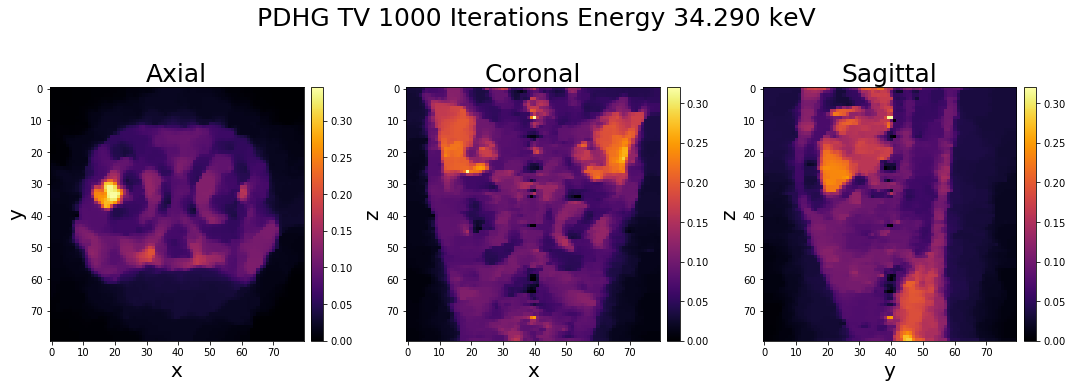

In [6]:
# Load in 1000 iteration dataset
reader = NEXUSDataReader()
reader.set_up(nexus_file = 'pdhg_S_1000.nxs')
pdhg_S_1000 = reader.load_data()

# Show the result
show(pdhg_S_1000, title='PDHG TV 1000 Iterations', 
     show_channels=20, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 

## Exercise 1: Change correlation to Space-Channel

We can make some adjustments to our framework to see how these affect the reconstruction.
Our gradient component is capable of smoothing our reconstruction both in the spatial domain, but also in the energy domain, by comparing reconstructions to its neighbouring channel.

Try changing the gradient component of our operator, $\nabla$, so that it is correlated in both the spatial and energy channel domain. We can do this by simply setting:  
  
  `op1 = Gradient(ig, correlation='SpaceChannels')` 

Keep the tomography operator, $A$ the same. 

There are three numerical parameters that have an impact on the resulting reconstruction: alpha ($\alpha$), sigma ($\sigma$) and tau ($\tau$). For our original PDHG reconstruction, these optimum parameters were:  
$\alpha$ = 0.05,  
$\sigma$ = 1,  
$\tau$ = `1/(sigma*normK**2)`.

For this test, we'll adjust our parameters slightly to:  
$\alpha$ = 0.07,  
$\sigma$ = 1,  
$\tau$ = `1/(sigma*normK**2)`.    

See if you notice any difference when you visualise the new reconstruction.

In [ ]:
# Adjust the correlation of the gradient operator

### START CODE HERE ###

# Adjust correlation of gradient component

#op1 = Gradient(ig, correlation = "...")

op2 = A3DMC

# Construct new BlockOperator

K = BlockOperator(op1, op2)

# Define regularising parameter alpha

#alpha = ...

# Fidelity terms f1,f2

f1 = alpha * MixedL21Norm() 
f2 = 0.5 * L2NormSquared(b = data)

# Construct BlockFunction

F = BlockFunction(f1,f2)

# Positivity Constraint Function
G = IndicatorBox(lower = 0)

# Compute the operator norm for K

normK = K.norm()

# Define the step sizes sigma and tau

#sigma = ...
#tau = ...

### END CODE HERE ###

Once you've made these changes, have a go at running the reconstruction and see what influence your changes
had.

In [ ]:
pdhgSC = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma,
             max_iteration = 100, update_objective_interval = 25)
pdhgSC.run()

In [ ]:
show(pdhgSC.get_output(), title='PDHG TV Reconstruction', show_channels=20, cmap='inferno', figure_size = [15,6], font_size=[25,20]) 

We can directly compare the two types of PDHG reconstruction using `islicer`. As we move across energy channels, see if there are any major differences between the constructions:  
 1) PDHG TV using a Spatial correlation for 1000 iterations  
 2) PDHG TV using a Space-Channel correlation for 100 iterations
 
**Note:** If you also ran the earlier code for 100 iterations of PDHG TV using a Spatial correlation, feel free to add in an extra line to compare this too:  
`i3 = islicer(pdhg_S_100.subset(vertical=40),direction='channel',title='100 Iteration Space Corr.: Channel', cmap='inferno', minmax = (0.0,0.3))`


In [ ]:
i1 = islicer(pdhg_S_1000.subset(vertical=40),direction='channel',title='1000 Iteration Space Corr.: Channel', cmap='inferno', minmax = (0.0,0.3))
i2 = islicer(pdhgSC.get_output().subset(vertical=40),direction='channel',title='100 Iteration Space-Channel Corr.: Channel',cmap='inferno', minmax = (0.0,0.3))
link_islicer(i1,i2)

## Extracting Energy-based profiles

Once we have chosen and optimised our reconstruction routine, we can exploit this additional, energy dimension further by identifying the spectral signals that lie within.

First we can plot out energy profiles for any region-of-interest in our reconstructed slices. This allows us to find, for instance, an absorption edge.
Iodine has a known absorption 'K-edge' of 33.169 keV, so we can test the accuracy of reconstruction algorithms by seeing where this edge falls in each case. A plot of an idealised, theoretical Iodine K-edge is shown below, falling precisely at 33.169 keV.
<img src="images/Iodine_K_edge.png" width=800 height=800 align="center">
We start by extracting a 3x3 set of pixels from each of the 3D multi-channel datasets. We can choose the pixels with the highest signal by looking at our previous reconstructed images.

In [ ]:
# Collect 3x3 regions of interest for each dataset

# FDK Recon
# Sum along z-direction (vertical)
fdk_ROI1 = np.mean(fdk.get_output().as_array()[:,42:45,:,:],1)
# Sum along y-direction (horizontal_y)
fdk_ROI2 = np.mean(fdk_ROI1[:,31:34,:],1)
# Sum along x-direction (horizontal_x)
fdk_ROI3 = np.mean(fdk_ROI2[:,14:17],1)

# 3D multi-channel 10 iteration CGLS
cgls_ROI1 = np.mean(cgls.get_output().as_array()[:,42:45,:,:],1)
cgls_ROI2 = np.mean(cgls_ROI1[:,31:34,:],1)
cgls_ROI3 = np.mean(cgls_ROI2[:,14:17],1)

# 3D multi-channel space correlated PDHG
pdhg_S_1000_ROI1 = np.mean(pdhg_S_1000.as_array()[:,42:45,:],1)
pdhg_S_1000_ROI2 = np.mean(pdhg_S_1000_ROI1[:,31:34],1)
pdhg_S_1000_ROI3 = np.mean(pdhg_S_1000_ROI2[:,14:17],1)

# 3D multi-channel space-channel correlated PDHG TV
pdhgSC_ROI1 = np.mean(pdhgSC.get_output().as_array()[:,42:45,:],1)
pdhgSC_ROI2 = np.mean(pdhgSC_ROI1[:,31:34],1)
pdhgSC_ROI3 = np.mean(pdhgSC_ROI2[:,14:17],1)

In [ ]:
# Set channel numbers for reduced dataset
channel_no = np.linspace(100,140,num_channels)
# Apply linear calibration equation to convert channels to energy
e_keV = 0.2786*channel_no + 0.8575

plt.figure(figsize=(8,6))

plt.plot(e_keV,fdk_ROI3)
plt.plot(e_keV,cgls_ROI3) 
plt.plot(e_keV,pdhg_S_1000_ROI3)
plt.plot(e_keV,pdhgSC_ROI3)

plt.plot((33.169,33.169),plt.ylim(0.0,0.4))

plt.legend(labels=['FDK', 'Simple CGLS', 'Space Corr. 1000 Iter. PDHG', 
                   'Space-Channel Corr. 100 Iter. PDHG', 'I K-edge 33.169 keV'])
plt.ylim(0.1,0.3)
plt.xlim([29,39])

plt.ylabel('Optical Density (no units)')
plt.xlabel('Energy (keV)')

From our plots, we can see all algorithms experience a sharp rise in signal value due to the iodine absorption K-edge. Compared to the theoretical value line, each of the cases match well with the expected position of the edge.
An important factor to note is the increased smoothness of the signal for PDHG TV, when a 'Space-Channel' correlation is applied to our gradient operator for these methods. This correlation enforces our operator to use the previous energy channel as a reference point for reconstructing data in the next, resulting in a smoother transition across channels.

## Exercise 2: Move to 2D Spatial Geometry with Channels
### Defining 2D `Acquisition/Image Geometry` and `Projector`

From our 4D dataset, we can reduce the dimensionality by taking a single slice along a particular spatial dimension. 
We can go from a shape of 

                (Channel, Vertical, Angle, Horizontal) = (40, 80, 60, 80)  
to a shape of 

                        (Channel, Angle, Horizontal) = (40, 60, 80)  
by taking a vertical slice subset.

Let's start by reducing our original `AcquisitionData`. For simplicity, choose a central slice subset by setting:  

`data2DMC = data.subset(vertical=40)`  
`ag2d = data2DMC.geometry`  

This will set our new `AcquisitionGeometry`.

We must then alter the dimensionality of `ag2d`. Currently this is stored as `'3D'`, but as we now use only 2 spatial dimensions, we must change it to `'2D'`. So we can do:  
  
`ag2d.dimension = '2D'`

In [ ]:
# Take a central slice of the AcquisitionData
# Adjust the dimension of the new AcquisitionGeometry

### START CODE HERE ### 

#data2DMC = ...
#ag2d = ...
#ag2d.dimension = ...

### END CODE HERE ### 

We still need to manually adjust the `ImageGeometry` parameters we used for the [4D dataset](#4D_Acquisition_Image_Geometry). 
Below we have the parameters used for the original dataset.  
Which parts of this geometry do we no longer need?  
**Delete** what's not needed and then run the code.

In [ ]:
# Setup the ImageGeometry for 2D plus channels

### START CODE HERE ### 

#ig2d = ImageGeometry(voxel_num_x=ag.pixel_num_h, 
#                     voxel_num_y=ag.pixel_num_h,
#                     voxel_num_z=ag.pixel_num_h,
#                     voxel_size_x=ag.pixel_size_h/mag, 
#                     voxel_size_y=ag.pixel_size_h/mag, 
#                     voxel_size_z=ag.pixel_size_h/mag, 
#                     channels=num_channels)

### END CODE HERE ### 

Now we can setup the tomography operator for 2D multi-channel data using the redefined `AcquisitionGeometry` and `ImageGeometry` for 2D. Let's call it `A2DMC`.

Remember: Last time we used [AstraProjector3DMC](#A3DMC) as we had a 3D multi-channel dataset. Here we instead use `AstraProjectorMC()`.

Note: While `AstraProjector3DMC` required the use of `gpu`, we can setup our 2D multi-channel tomography operator using either `gpu` or `cpu`. The default is the use of `gpu`.

In [ ]:
# Setup the tomography operator for 2D plus channels

### START CODE HERE ### 

#A2DMC = AstraProjectorMC(...)

### END CODE HERE ### 

## Exercise 3: Running 2D plus channel CGLS

In this exercise, use what you've learned about setting up reconstruction routines, and perform a simple CGLS using our 2D multi-channel data. Then run it for 10 iterations.

Remember, the key parameters you need are:
 - initialisation x_init (`A2DMC.volume_geometry.allocate()`)
 - operator (`A2DMC`)
 - data (`data2DMC`)
 
 

In [ ]:
# Initialise the tomography operator

### START CODE HERE ### 

#x_init = ...

### END CODE HERE ### 

In [ ]:
# Setup the algorithm

### START CODE HERE ### 

#cgls2d = CGLS(x_init =..., operator = ..., data = ..., max_iteration = )

# Run the algorithm for 10 iterations

#cgls2d.run(...)

### END CODE HERE ### 

You can check the results of your reconstruction by running the function `show` below, giving you axial views for two energy channels. Or run an interactive slicer across energy channels.

In [ ]:
# Show reconstruction 
show(cgls2d.get_output(), title='2D Multi-Channel CGLS', show_channels=[20,30], 
     cmap='inferno', figure_size = [10,5], font_size=[15,10])

In [ ]:
islicer(cgls2d.get_output(),direction='channel',title='Channel',cmap='inferno',minmax=(0.0,0.3))

## Exercise 4: Running 2D plus channel regularised CGLS

Here we will expand upon what you learned about BlockFrameworks. In particular, we will cover both `BlockOperators` and `BlockDataContainers`, which were covered in **Notebook 02_Tikhonov_Block_Framework**.

Below gives a brief definition of each type:

`BlockDataContainer` holds datacontainers as a column vector.

`BlockOperator` is a matrix of operators.

### Setting up Regularised CGLS

For our regularisation, we wish to solve:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{\alpha \nabla}{A} u - \binom{0}{g}\end{Vmatrix}^2_2$$
With the definitions:

$\tilde{A} = \binom{\alpha \nabla}{A} \quad\Longleftrightarrow\quad$ `BlockOperator(alpha*Gradient(ig2d),A2DMC)`  
(where $\alpha$ is the regularisation parameter)

$\tilde{g} = \binom{0}{g} \quad\Longleftrightarrow\quad$ `BlockDataContainer(op1.range_geometry().allocate(),data2DMC)`

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{g}\end{Vmatrix}^2_2$$
and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{g}$ as data.

### Build `BlockOperator`

Using the 2D multi-channel data and geometry constructed above, build a `BlockOperator`, $\tilde{A}$, applying a Space-Channel correlation.  
Choose a regularisation value around $\alpha$ = 1.5 as a starting point.

In [ ]:
# Set up operators for BlockOperator

### START CODE HERE ### 

#op1 = Gradient(..., correlation='...')
#op2 = ...
#alpha = ...
#A_block = BlockOperator(...)

### END CODE HERE ### 

### Build `BlockDataContainer`

Next build a `BlockDataContainer`, $\tilde{g}$, containing an array with the range of the regularising operator, $\alpha \nabla$, and our reduced `AcquisitionData` (`data2DMC`).

In [ ]:
# Create BlockDataContainer

### START CODE HERE ### 

#g_block = BlockDataContainer(...)

### END CODE HERE ### 

### Initialise and Run

Now we can initialise the `BlockOperator` and run the algorithm for 50 iterations.

In [ ]:
# Initialise the BlockOperator

x_init = A_block.domain_geometry().allocate()

# Setup and run the regularised CGLS algorithm

cgls_reg = CGLS(x_init = x_init, operator = A_block, data = g_block,
                max_iteration = 100,update_objective_interval = 10)
cgls_reg.run(50)

In [ ]:
# Show reconstruction 
show(cgls_reg.get_output(), show_channels=[20,30], title='2D Multi-Channel Regularised CGLS', cmap='inferno', figure_size = [10,5], font_size=[15,10])

While still noisy, we can see a significant improvement in contrast to the CGLS algorithm when no regularisation is applied. The `islicer` below allows you to directly compare the two reconstructions.

In [ ]:
i1 = islicer(cgls2d.get_output(),direction='channel',title='Simple CGLS: Channel',
             cmap='inferno',minmax=(0.0,0.3))
i2 = islicer(cgls_reg.get_output(),direction='channel',title='Regularised CGLS: Channel',
             cmap='inferno',minmax=(0.0,0.3))
link_islicer(i1,i2)

## Exercise 5: 2D Multi-channel Total Variation with PDHG

Now let's test our reduced dataset with the PDHG algorithm using Total Variation regularisation.

Based on what our construction looked like for the 4D version, try to recreate this for our 2D multi-channel data. You'll need to adjust the `BlockOperator`, $K$ and `BlockFunction`, $\mathcal{F}$, accordingly.

Play around with the numeric parameters ($\alpha$, $\sigma$ and $\tau$) as well, and see how they affect the reconstruction here. Is there a big change when moving from 3D multi-channel to 2D multi-channel?

In [ ]:
# Setup the BlockOperator, K

### START CODE HERE ### 

#op1 = ...
#op2 = ...
#K = BlockOperator(op1,op2)

# Define the regularising parameter, alpha

#alpha = ...

# Setup the BlockFunction, F

#f1 = ...
#f2 = ...
#F = BlockFunction(f1,f2)

# Define indicator function that provides a positivity constraint

#G = ...

# Compute the operator norm for K

#normK = ...

# Define the step sizes sigma and tau

#sigma = ...
#tau = ...

### END CODE HERE ### 

In [ ]:
# Setup and run the PDHG algorithm

### START CODE HERE ### 

#pdhg_2d = PDHG(...)
#pdhg_2d.run(...)

### END CODE HERE ### 

In [ ]:
# Show reconstruction 
show(pdhg_2d.get_output(), show_channels=[15,30], title='2D Multi-Channel TV PDHG', cmap='inferno', figure_size = [10,5], font_size=[15,10])

In [ ]:
islicer(pdhg_2d.get_output(),direction='channel',title='Channel',cmap='inferno',minmax = (0.0,0.3))

## Energy profiles

Once more we can extract energy profiles, to determine the K-edge position in our 2D multi-channel datasets.
In this case, we extract a 3x3 set of pixels by only summing along two spatial domains, y (`horizontal_y`) and x (`horizontal_x`).

In [ ]:
# Collect 3x3 regions of interest for each dataset

# 2d multi-channel simple CGLS
# Sum along y-direction
cgls2d_ROI1 = np.mean(cgls2d.get_output().as_array()[:,33:36,:],1)
# Sum along x-direction
cgls2d_ROI2 = np.mean(cgls2d_ROI1[:,60:63],1)

# 2d multi-channel regularised CGLS
cgls_reg_ROI1 = np.mean(cgls_reg.get_output().as_array()[:,33:36,:],1)
cgls_reg_ROI2 = np.mean(cgls_reg_ROI1[:,60:63],1)

# 2d multi-channel PDHG TV
#pdhg_2d_ROI1 = np.mean(pdhg_2d.get_output().as_array()[:,33:36,:],1)
#pdhg_2d_ROI2 = np.mean(pdhg_2d_ROI1[:,60:63],1)


In [ ]:
# Set channel numbers for reduced dataset
channel_no = np.linspace(100,140,num_channels)
# Apply linear calibration equation to convert channels to energy
e_keV = 0.2786*channel_no + 0.8575

plt.figure(figsize=(8,6))

plt.plot(e_keV,cgls2d_ROI2) 
plt.plot(e_keV,cgls_reg_ROI2)
#plt.plot(e_keV,pdhg_2d_ROI2)

plt.plot((33.169,33.169),plt.ylim(0.0,0.4))

plt.legend(labels=['Simple CGLS', 'Regularised (Space-Channel) CGLS', 'I K-edge 33.169 keV'])
plt.ylim(0.1,0.4)
plt.xlim([29,39])

plt.ylabel('Optical Density (no units)')
plt.xlabel('Energy (keV)')

## Constructing Elemental Maps

Once we know have identified the position of this edge in our energy profile, we can narrow our dataset and produce an 'Iodine map'. That is, we can select only the energy channels occupied by the absorption edge, so all reconstructed signal is now due only to the iodine contrast agent. This method is known as **'K-edge subtraction'**, which you can read about in more detail in papers such as that by [C.K.Egan *et al*, 2015](https://www.nature.com/articles/srep15979#).  
A basic concept is shown below for our energy profile plot. The hashed area highlights the energy range we are interested in, corresponding to the absorption edge.

<img src="images/Kedge_Sub.png" width=600 height=600 align="center">

Based on our plots, we will estimate the start and end of the edge to occur at approximately 32.5 keV and 34 keV respectively.

In [ ]:
# Calculate energy channels corresponding to start and end of the K-edge
e_keV = np.array([32.5,34])
channel_no = ((e_keV-0.8575)/0.2786)-100

# Display the channels corresponding to the start and end of the K-edge
print("Start of edge = channel",int(channel_no[0]))
print("End of edge = channel",int(channel_no[1]))


In [ ]:
# 2d multi-channel simple CGLS
# Sum over all pixels for channels of interest
cgls2d_COI = np.mean(cgls2d.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)

# 2d multi-channel regularised CGLS
cgls_reg_COI = np.mean(cgls_reg.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)

# 2d multi-channel PDHG TV
#pdhg_2d_COI = np.mean(pdhg_2d.get_output().as_array()[int(channel_no[0]):int(channel_no[1]),:,:],0)


In [ ]:
# Collect together iodine maps
stack_maps = (np.array([cgls2d_COI, cgls_reg_COI]))
print('Plot 0 = Simple CGLS\nPlot 1 = Regularised CGLS')
islicer(stack_maps, title='Comparison of Iodine Maps', direction=0, cmap='inferno',minmax = (0.0,0.3))

In [ ]:
# Plot iodine maps for each reconstruction
plt.imshow(cgls2d_COI,cmap='inferno'), plt.title('Simple CGLS Iodine map'), plt.colorbar()

In [ ]:
plt.imshow(cgls_reg_COI,cmap='inferno'), plt.title('Regularised CGLS Iodine map'), plt.colorbar()

In [ ]:
plt.imshow(pdhg_2d_COI,cmap='inferno'), plt.title('TV PDHG Iodine map'), plt.colorbar()

Finally we can bring together the 2D multi-channel reconstructions we have performed for:
 - Simple CGLS
 - Regularised CGLS
 - PDHG with TV  
 
Using the `islicer` tool, we can directly compare these reconstructions side-by-side and evaluate the level of noise removal and spatial/energy smoothing offered by each method.

In [ ]:
s1 = islicer(cgls2d.get_output(), direction = 'channel', title = 'Simple CGLS: Channel',cmap='inferno',minmax = (0.0,0.3))
s2 = islicer(cgls_reg.get_output(), direction = 'channel', title = 'Regularised CGLS: Channel',cmap='inferno',minmax = (0.0,0.3))
#s3 = islicer(pdhg_2d.get_output(), direction = 'channel', title = 'TV PDHG: Channel',cmap='inferno',minmax = (0.0,0.3))
link_islicer(s1,s2)

<h1><center>Conclusions</center></h1>

This notebook focused on bringing together the core elements of the CIL framework you have learned in the previous courses, and seeing how these may be applied to a multi-channel dataset. 

We looked at the key differences in building Image/Acquisition Geometries and Operators for multi-channel datasets, and how these vary for both 2D and 3D multi-channel.

We have covered three key algorithms (FDK, CGLS and PDHG) and shown the differences between these for both 2D and 3D multi-channel. This also allowed us to explore some of the ways in which we can vary these reconstruction routines, and how making these adjustments can have significant effects on the quality of your reconstructions.

Finally we have shown the ability to extract spectral properties from the reconstruction, providing an insight to the elemental composition of the sample of interest using energy profiles and elemental maps.

**Click the link below to see the potential for full volume reconstructions using both CGLS (Left) and PDHG TV (Right)**  
[4D Lizard Full Volume Reconstruction](images/Lizard_gif.gif "segment")